In [1]:
#####################
# LIBRARIES IMPORTS #
#####################

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Loading the data into Pandas' Dataframe

The dataset provided is composed of a "lighter_authors.json" file of about 0.5 Gbs and a "lighter_books.json" file of about 15 Gbs. Considering that where will be a data-type conversion the dataset will become even bigger when loaded on pandas and they could not work on machines with limited amounts of RAM. We can approach this problem from two sides:
* Divide the dataset in chunks, work one chunk at a time and merge the result.
* For every request we could extract only the columns we are interested with.

Both this approach are slow, we have to load every part of the dataset from the storage and load it on RAM for every exercise, and this increase considerably the amount of time to execute each query. Instead we try to load everything all at once, making the dataset lighter by removing columns useless for our analysis and where possible changing the data-type of useful columns to lighter versions.

## Authors dataset

In [2]:
# load the dataset from the .json file to a pandas dataframe
authors = pd.read_json("datasets/lighter_authors.json", lines = True)

In [5]:
# check the first lines of the dataframe
authors.head()

,ratings_count,average_rating,text_reviews_count,work_ids,book_ids,works_count,id,name,gender,image_url,about,fans_count
0,2862064,4.19,62681,"[3078186, 135328, 1877624, 74123, 3078120, 104...","[386162, 13, 8695, 8694, 6091075, 365, 569429,...",106,4,Douglas Adams,male,https://images.gr-assets.com/authors/159137433...,"Douglas Noël Adams was an English author, comi...",19826
1,1417316,4.02,84176,"[613469, 2305997, 940892, 2611786, 7800569, 31...","[9791, 21, 28, 24, 7507825, 27, 10538, 25, 26,...",75,7,Bill Bryson,male,https://images.gr-assets.com/authors/157859752...,"William McGuire ""Bill"" Bryson, OBE, FRS was bo...",16144
2,56159,4.53,352,"[17150, 808427, 20487307, 90550, 25460625, 171...","[349254, 15222, 14833682, 15221, 18126815, 152...",14,10,Jude Fisher,female,https://images.gr-assets.com/authors/141145711...,"Jude Fisher is the pseudonym for <a href=""http...",60
3,3302,3.79,480,"[4417, 14300808, 14780, 3796968, 44703121, 103...","[40, 9416484, 12482, 3753106, 26889789, 104764...",45,12,James Hamilton-Paterson,male,https://images.gr-assets.com/authors/127051738...,James Hamilton-Paterson's work has been transl...,72
4,7979,3.60,772,"[13330815, 19109351, 42306244, 72694240, 26291...","[8466327, 15739968, 22756778, 51026133, 260451...",61,14,Mark Watson,male,https://images.gr-assets.com/authors/133175379...,Mark Andrew Watson (born 13 February 1980) is ...,179


In [3]:
# check some infos about each column
authors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351767 entries, 0 to 351766
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ratings_count       351767 non-null  int64  
 1   average_rating      351767 non-null  float64
 2   text_reviews_count  351767 non-null  int64  
 3   work_ids            351767 non-null  object 
 4   book_ids            351767 non-null  object 
 5   works_count         351767 non-null  int64  
 6   id                  351767 non-null  int64  
 7   name                351767 non-null  object 
 8   gender              351767 non-null  object 
 9   image_url           351767 non-null  object 
 10  about               351767 non-null  object 
 11  fans_count          351767 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 32.2+ MB


In [7]:
# check some infos about the RAM usage of every column
raw_authors_memory_usage = authors.memory_usage(index = True, deep = True)
raw_authors_memory_usage

Index                       132
ratings_count           2814136
average_rating          2814136
text_reviews_count      2814136
work_ids               80361120
book_ids               80361120
works_count             2814136
id                      2814136
name                   26225127
gender                 21266267
image_url              44826054
about                 410897740
fans_count              2814136
dtype: int64

In [10]:
print("The dataset just as imported uses", round(raw_authors_memory_usage.sum() / 1073741824, 2), "GBs of RAM!" )
print("The 'about' column covers", round(raw_authors_memory_usage["about"] / raw_authors_memory_usage.sum(), 2) * 100, "% of the total RAM usage alone!")

The dataset just as imported uses 0.63 GBs of RAM!
The 'about' column covers 60.0 % of the total RAM usage alone!


The columns "image_url" and "about" are useless for our analysis so they can be removed.

In [3]:
# remove the useless columns
authors.drop(columns = ["image_url", "about"], inplace = True)
print("The dataset now uses", round(authors.memory_usage(index = True, deep = True).sum() / 1073741824, 2), "GBs of RAM!" )

The dataset now uses 0.21 GBs of RAM!


[TODO] CHANGE DATA TYPES?

## Books

The books dataset is much bigger than the authors one and we can't work with it in one go, we have to separate it in chunks. Firstly we analyze what can be done with it by only observing some rows

In [4]:
# load a chunk of the dataset from the .json file to a pandas dataframe
books = pd.read_json("datasets/lighter_books.json", lines = True, nrows = 10000)

In [9]:
# check the first lines of the chunk
books.head()

,id,title,authors,author_name,author_id,work_id,isbn,isbn13,asin,language,...,format,edition_information,image_url,publisher,num_pages,series_id,series_name,series_position,shelves,description
0,2,Harry Potter and the Order of the Phoenix (Har...,"[{'id': '1077326', 'name': 'J.K. Rowling', 'ro...",J.K. Rowling,1077326,2809203,0439358078,9780439358071,,eng,...,Paperback,US Edition,https://i.gr-assets.com/images/S/compressed.ph...,Scholastic Inc.,870,45175,Harry Potter,5,"[{'name': 'to-read', 'count': 324191}, {'name'...",There is a door at the end of a silent corrido...
1,3,Harry Potter and the Sorcerer's Stone (Harry P...,"[{'id': '1077326', 'name': 'J.K. Rowling', 'ro...",J.K. Rowling,1077326,4640799,,,,eng,...,Hardcover,Library Edition,https://i.gr-assets.com/images/S/compressed.ph...,Scholastic Inc,309,45175,Harry Potter,1,"[{'name': 'fantasy', 'count': 63540}, {'name':...",Harry Potter's life is miserable. His parents ...
2,4,Harry Potter and the Chamber of Secrets (Harry...,None,J.K. Rowling,1077326,6231171,0439554896,9780439554893,,eng,...,Hardcover,,https://i.gr-assets.com/images/S/compressed.ph...,Scholastic,352,45175,Harry Potter,2,"[{'name': 'to-read', 'count': 282341}, {'name'...",The Dursleys were so mean and hideous that sum...
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,"[{'id': '1077326', 'name': 'J.K. Rowling', 'ro...",J.K. Rowling,1077326,2402163,043965548X,9780439655484,,eng,...,Mass Market Paperback,,https://i.gr-assets.com/images/S/compressed.ph...,Scholastic Inc.,435,45175,Harry Potter,3,"[{'name': 'to-read', 'count': 292815}, {'name'...","For twelve long years, the dread fortress of A..."
4,6,Harry Potter and the Goblet of Fire (Harry Pot...,"[{'id': '1077326', 'name': 'J.K. Rowling', 'ro...",J.K. Rowling,1077326,3046572,,,,eng,...,Paperback,First Scholastic Trade Paperback Edition,https://i.gr-assets.com/images/S/compressed.ph...,Scholastic,734,45175,Harry Potter,4,"[{'name': 'to-read', 'count': 287086}, {'name'...",Harry Potter is midway through his training as...


In [10]:
# check some infos about each column
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         9999 non-null   int64  
 1   title                      9999 non-null   object 
 2   authors                    3742 non-null   object 
 3   author_name                9999 non-null   object 
 4   author_id                  9999 non-null   int64  
 5   work_id                    9999 non-null   int64  
 6   isbn                       9999 non-null   object 
 7   isbn13                     9999 non-null   object 
 8   asin                       9999 non-null   object 
 9   language                   9999 non-null   object 
 10  average_rating             9999 non-null   float64
 11  rating_dist                9999 non-null   object 
 12  ratings_count              9999 non-null   int64  
 13  text_reviews_count         9999 non-null   int64

In [11]:
# check some infos about the RAM usage of every column
raw_books_memory_usage = books.memory_usage(index = True, deep = True)
raw_books_memory_usage

Index                             132
id                              79992
title                          929445
authors                        455800
author_name                    713677
author_id                       79992
work_id                         79992
isbn                           667069
isbn13                         696731
asin                           570003
language                       588070
average_rating                  79992
rating_dist                    972520
ratings_count                   79992
text_reviews_count              79992
publication_date               651619
original_publication_date      637722
format                         652179
edition_information            592564
image_url                     1484359
publisher                      707782
num_pages                      398205
series_id                      584280
series_name                    619446
series_position                573670
shelves                       5910832
description 

In [12]:
print("The dataset just as imported uses", round(raw_books_memory_usage.sum() / 1073741824, 2), "GBs of RAM!" )
print("The 'about' column covers", round(raw_books_memory_usage["description"] / raw_books_memory_usage.sum(), 2) * 100, "% of the total RAM usage alone!")

The dataset just as imported uses 0.03 GBs of RAM!
The 'about' column covers 35.0 % of the total RAM usage alone!


The scenario is similar to the authors dataset, there is a column of long text descriptions that occupy a large amount of memory and it's useless to us. We remove it together with other useless columns such as "image_url", "isb", "isbn13", "asin" [TODO].

In [5]:
# remove the useless columns
books.drop(columns = ["isbn", "isbn13", "asin", "edition_information", "publisher", "image_url", "description", "shelves"], inplace = True)
print("The dataset now uses", round(books.memory_usage(index = True, deep = True).sum() / 1073741824, 2), "GBs of RAM!" )

The dataset now uses 0.01 GBs of RAM!


Now we try to load the whole books dataset, chunk by chunk, and removing the useless parts.

In [17]:
books = pd.DataFrame()

chunk_size = 100000
chunks = pd.read_json("datasets/lighter_books.json", lines = True, chunksize = chunk_size)
col_to_drop = ["isbn", "isbn13", "asin", "edition_information", "image_url", "publisher", "shelves", "description"]
 
for chunk in chunks:
    chunk.drop(columns = col_to_drop, inplace = True)
    books = pd.concat([books, chunk])
    

In [7]:
# check some infos about each column
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7027431 entries, 0 to 7027430
Data columns (total 17 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   id                         int64  
 1   title                      object 
 2   authors                    object 
 3   author_id                  int64  
 4   work_id                    int64  
 5   language                   object 
 6   average_rating             float64
 7   rating_dist                object 
 8   ratings_count              int64  
 9   text_reviews_count         int64  
 10  publication_date           object 
 11  original_publication_date  object 
 12  format                     object 
 13  num_pages                  object 
 14  series_id                  object 
 15  series_name                object 
 16  series_position            object 
dtypes: float64(1), int64(5), object(11)
memory usage: 911.5+ MB


In [8]:
# check some infos about the RAM usage of every column
books_memory_usage = books.memory_usage(index = True, deep = True)
books_memory_usage


Index                              132
id                            56219448
title                        684810631
authors                      293131784
author_id                     56219448
work_id                       56219448
language                     408879894
average_rating                56219448
rating_dist                  630673989
ratings_count                 56219448
text_reviews_count            56219448
publication_date             443850344
original_publication_date    453898624
format                       442678021
num_pages                    317496071
series_id                    410544811
series_name                  435058804
series_position              402850062
dtype: int64

In [9]:
print("The dataset uses", round(books_memory_usage.sum() / 1073741824, 2), "GBs of RAM!" )

The dataset uses 4.9 GBs of RAM!


# [RQ1] Exploratory Data Analysis (EDA)

TODO

In the Authors dataset what's the difference between "book" and "work"?

The Books dataset has some void string entries in the num_pages column.

# [RQ2] Let’s finally dig into this vast dataset, retrieving some vital information:

**Request 2.1:** Plot the number of books for each author in descending order.

**Request 2.2:**  Which book has the highest number of reviews?

In [19]:
books[books["text_reviews_count"] >= max(books["text_reviews_count"])]

,id,title,authors,author_id,work_id,language,average_rating,rating_dist,ratings_count,text_reviews_count,publication_date,original_publication_date,format,num_pages,series_id,series_name,series_position
5182806,19304768,"The Hunger Games (Hunger Games, #1)",None,153394,2792775,en-US,4.32,5:3572190|4:1993815|3:772952|2:178537|1:97671|...,6615165,174524,,2008-09-14,,,73758,The Hunger Games,1


**Request 2.3:** Which are the top ten and ten worst books concerning the average score?

In [26]:
books.nlargest(10, "average_rating")

,id,title,authors,author_id,work_id,language,average_rating,rating_dist,ratings_count,text_reviews_count,publication_date,original_publication_date,format,num_pages,series_id,series_name,series_position
178,238,Later Letters of Edward Lear to Chichester For...,None,142,4580,,5.0,5:4|4:0|3:0|2:0|1:0|total:4,4,2,,1907-01-01,,,,,
386,529,Lord of the Flies Activity Pack,None,10685776,19190202,,5.0,5:1|4:0|3:0|2:0|1:0|total:1,1,0,,,,,,,
653,1045,Bernie Mac,None,682,5252,,5.0,5:2|4:0|3:0|2:0|1:0|total:2,2,0,2006-07-01,2006-07-31,Hardcover,32,,,
671,1072,Delaware 1638-1776 (Voices from Colonial America),"[{'id': '8305468', 'name': 'National Geographi...",8305468,5279,,5.0,5:1|4:0|3:0|2:0|1:0|total:1,1,0,2006-08-08,2006,Hardcover,112,256625,Voices from Colonial America,
721,1179,"Simply Italian: 100 Easy-To-Make, Zesty, Satis...","[{'id': '781', 'name': 'Ruth Glick', 'role': '...",781,5374,,5.0,5:1|4:0|3:0|2:0|1:0|total:1,1,0,1999-03-31,1998,Paperback,161,,,
762,1272,Rudolph Giuliani,None,847,5454,,5.0,5:3|4:0|3:0|2:0|1:0|total:3,3,1,2003-09-01,2003-03,Paperback,32,,,
1101,1748,"Singers, Heroes, and Gods in the Odyssey",None,1161,5872,,5.0,5:6|4:0|3:0|2:0|1:0|total:6,6,2,2010-10-05,1994-12-01,Paperback,264,,,
1120,1773,Fanaroff and Martin's Neonatal-Perinatal Medic...,"[{'id': '327620', 'name': 'Avroy A. Fanaroff',...",327620,5897,,5.0,5:4|4:0|3:0|2:0|1:0|total:4,4,0,2005-09-01,2001-08-17,Hardcover,2036,,,
1213,1975,A Den Of Thieves,None,1331,6053,,5.0,5:1|4:0|3:0|2:0|1:0|total:1,1,0,,1995,,,,,
1252,2034,Comoediae 1: Acharenses/Equites/Nubes/Vespae/P...,"[{'id': '1011', 'name': 'Aristophanes', 'role'...",1011,17114130,grc,5.0,5:1|4:0|3:0|2:0|1:0|total:1,1,0,1922-02-22,1922-10-05,hardback,364,,,


In [27]:
books.nsmallest(10, "average_rating")

,id,title,authors,author_id,work_id,language,average_rating,rating_dist,ratings_count,text_reviews_count,publication_date,original_publication_date,format,num_pages,series_id,series_name,series_position
526,854,A More Perfect Way,None,4429527,5083,,0.0,5:0|4:0|3:0|2:0|1:0|total:0,0,0,2002-08-01,2002,Audio Cassette,,,,
527,855,Fields of Gold,None,4098147,5084,,0.0,5:0|4:0|3:0|2:0|1:0|total:0,0,0,2005-09-01,2005,Paperback,96,,,
530,860,Justitiemord: Fallet Keith Cederholm,None,260713,5088,,0.0,5:0|4:0|3:0|2:0|1:0|total:0,0,0,,1983,,,,,
570,927,The Rain Falls Like Rain: Poems,None,613,5148,,0.0,5:0|4:0|3:0|2:0|1:0|total:0,0,0,,1982,,204,,,
571,928,The Rain Falls Like Rain: Poems,None,613,5148,,0.0,5:0|4:0|3:0|2:0|1:0|total:0,0,0,,1982,,,,,
654,1050,Riches in Real Estate: A Beginner's Guide to G...,None,6538881,5257,,0.0,5:0|4:0|3:0|2:0|1:0|total:0,0,0,,1981,,,,,
772,1288,J.K.Lasser Pro Real Estate Investment Trusts: ...,None,855,5470,,0.0,5:0|4:0|3:0|2:0|1:0|total:0,0,0,2002-06-03,2002-06-15,Hardcover,372,,,
780,1302,Juiced Official Strategy Guide,None,86680,5479,eng,0.0,5:0|4:0|3:0|2:0|1:0|total:0,0,0,2005-06-01,2005-06-01,Paperback,112,,,
816,1348,The Platonism of Marsilio Ficino: A Study of H...,None,3970632,5522,,0.0,5:0|4:0|3:0|2:0|1:0|total:0,0,0,1984-01-01,1984,Unknown Binding,284,,,
1017,1596,The Nightingale Question: Five Poets from Saxony,None,610771,5732,,0.0,5:0|4:0|3:0|2:0|1:0|total:0,0,0,2004-07-15,2004-07-15,Paperback,108,,,


**Request 2.4:** Explore the different languages in the book’s dataset, providing a proper chart summarizing how these languages are distributed throughout our virtual library.

**Request 2.5:** How many books have more than 250 pages?

In [11]:
for elem in books["num_pages"]:
    if type(elem) != type(100):
        print("TROVATO")
        print(elem)
        print(type(elem))

        break

TROVATO

<class 'str'>


In [22]:
#books[books["num_pages"] > 250].shape()

**Request 2.6:** Plot the distribution of the fans count for the 50 most prolific authors (the ones who have written more books).

# [RQ3] Let’s have a historical look at the dataset!

# [RQ4] Quirks questions about consistency. In most cases, we will not have a consistent dataset, and the one we are dealing with is no exception. So, let's enhance our analysis.

# [RQ5] We can consider the authors with the most fans to be influential. Let’s have a deeper look.


*Provide information about the general response from readers (number of fans, average rating, number of reviews, etc.), divide the authors by gender, and comment about anything eventually related to “structural bias.”

**Request 5.1.a:** Plot the top 10 most influential authors regarding their fan count and number of books.

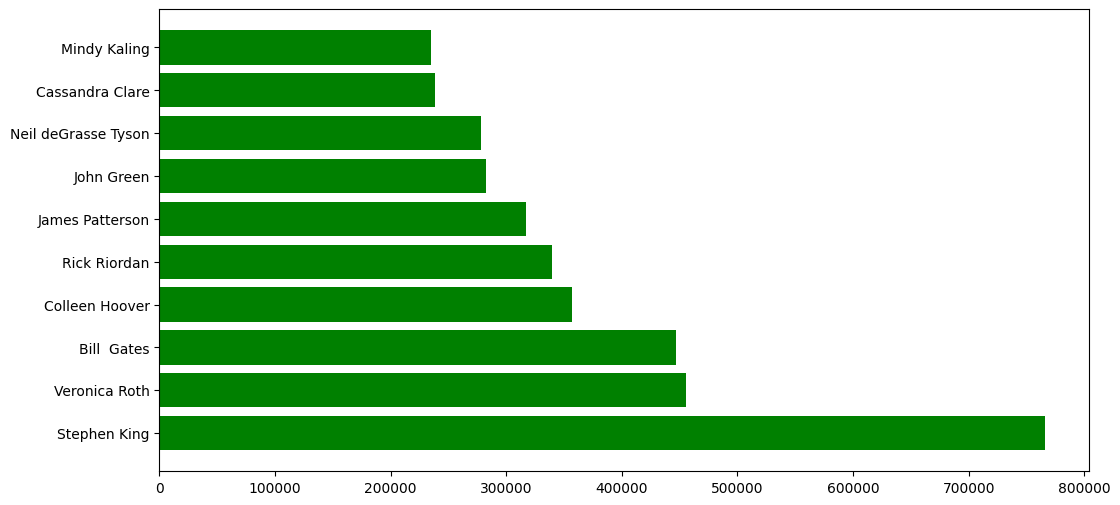

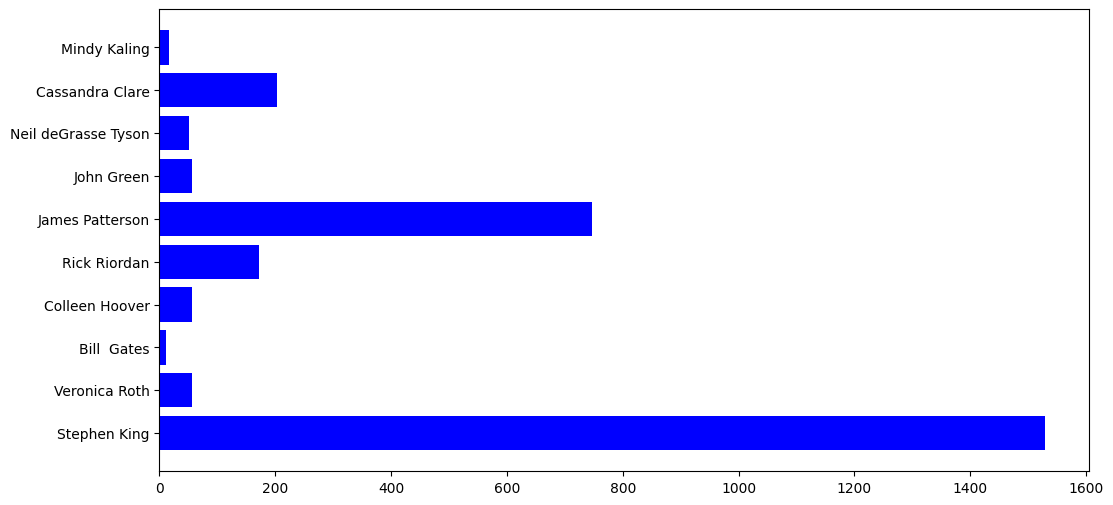

In [18]:
#Count the actual number of books written by every author using the length of the list of his book ids.
authors["book_count"] = authors["work_ids"].apply(len)

#10  most influential authors regarding their fan count
x = authors.nlargest(10, "fans_count")

#plot the data
plt.figure(figsize=(12,6))
plt.barh(x["name"], x["fans_count"], color = 'green', label = 'Fan Count')
plt.figure(figsize=(12,6))
plt.barh(x["name"], x["book_count"], color = 'blue', label = 'Book Count')
plt.show()

**Request 5.1.b:** Who is the most influential author?

In [19]:
#Most influential author

m_inf = authors.nlargest(1, "fans_count")
print("The most influential author, having by far the largest fanbase is:", m_inf["name"])

The most influential author, having by far the largest fanbase is: 1017    Stephen King
Name: name, dtype: object


**Request 5.2:** Have they published any series of books? If any, extract the longest series name among these authors.

In [36]:
#Create a new dataframe containing only the books written by the top 10 authors
top_authors_books = books[books["author_id"].isin(list(x["id"]))]

#Get the series authors by their "series position" to find who has written series, and use max position to determine their longest series' length.

author_series_lengths = top_authors_books.groupby(["author_id", "author_name"])["series_position"].max().reset_index()
#return the highest series position, thus the longest series author and name
author_series = top_authors_books.groupby(["author_id","author_name", "series_name"])["series_position"].max().reset_index()
max_series = author_series[author_series["series_position"] == author_series["series_position"].max()]


print("Authors of series are:")
print(author_series_lengths["author_name"])

print("\nThe author of the longest series")
print(max_series["author_name"])
print("And the series is:")
print(max_series["series_name"])


Authors of series are:
0           Stephen King
1        James Patterson
2    Neil deGrasse Tyson
3           Rick Riordan
4            Bill  Gates
5        Cassandra Clare
6           Mindy Kaling
7             John Green
8          Veronica Roth
9         Colleen Hoover
Name: author_name, dtype: object

The author of the longest series
70    Rick Riordan
Name: author_name, dtype: object
And the series is:
70    Percy Jackson and the Olympians
Name: series_name, dtype: object


**Request 5,2** How many of these authors have been published in different formats? Provide a meaningful chart on the distribution of the formats and comment on it.

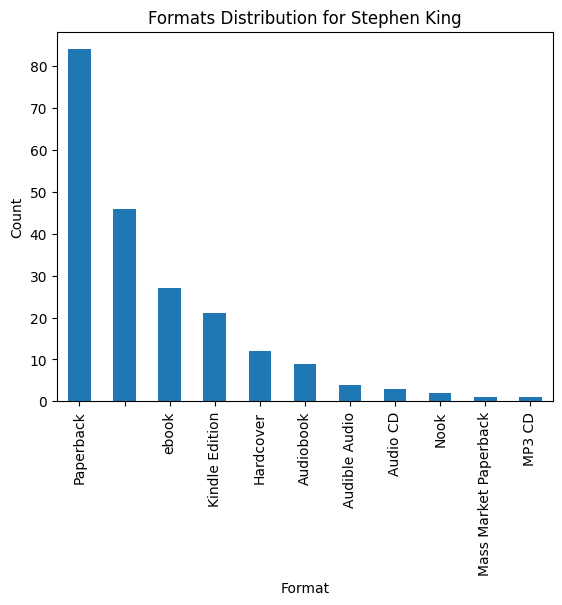

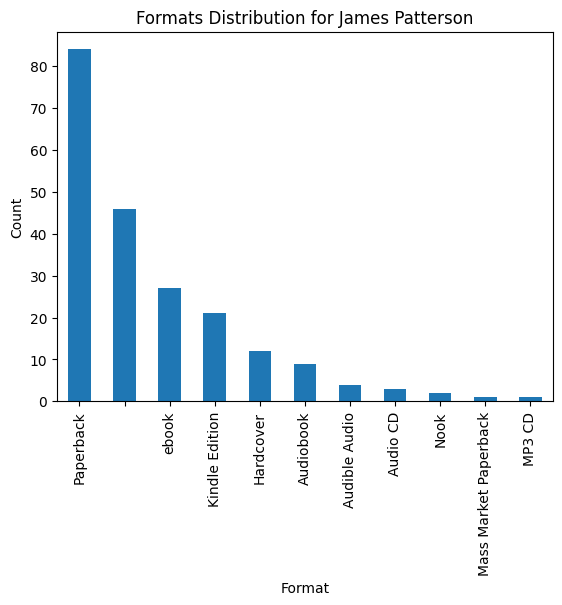

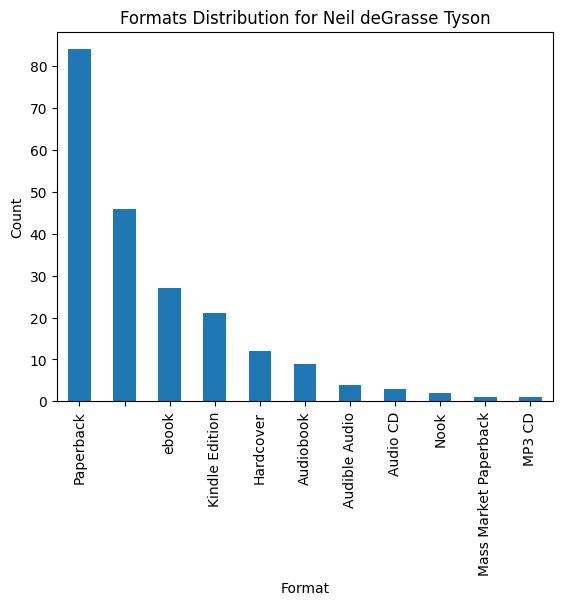

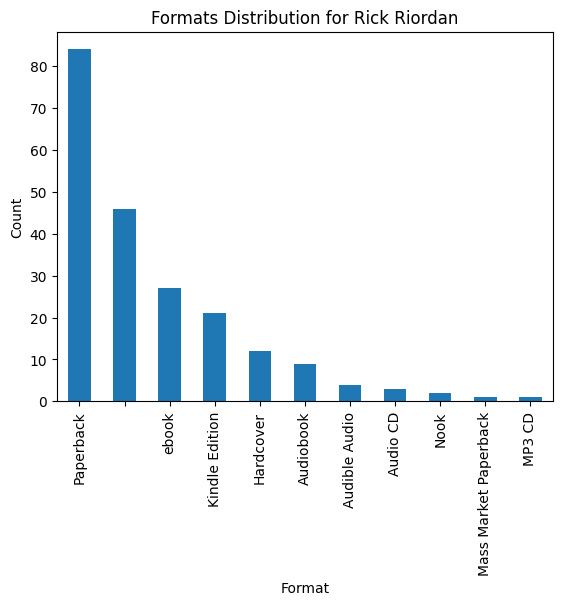

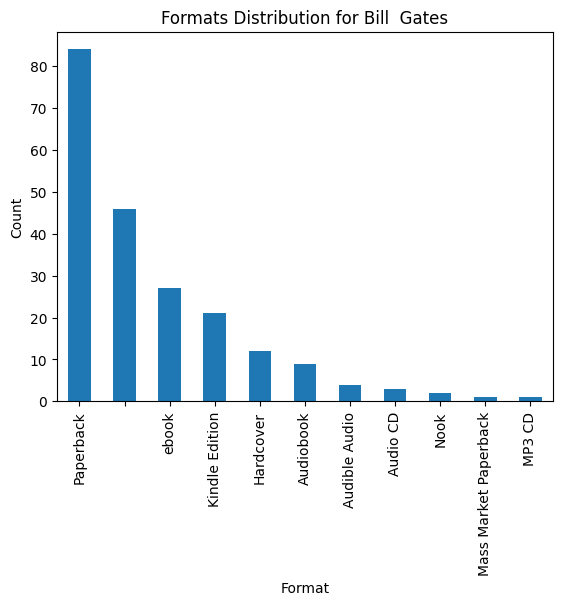

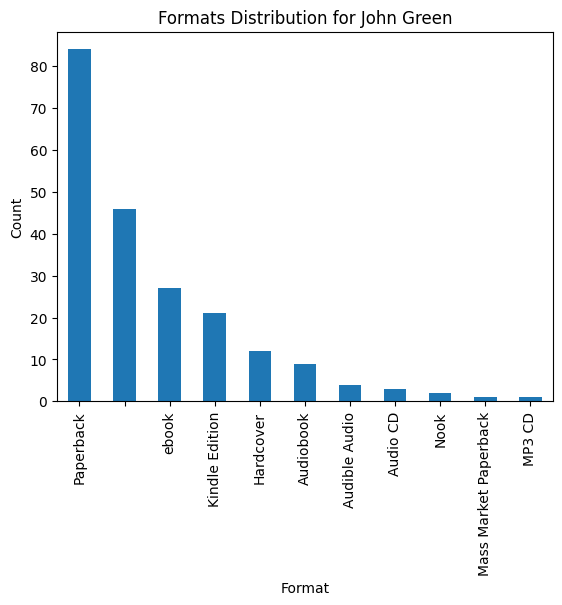

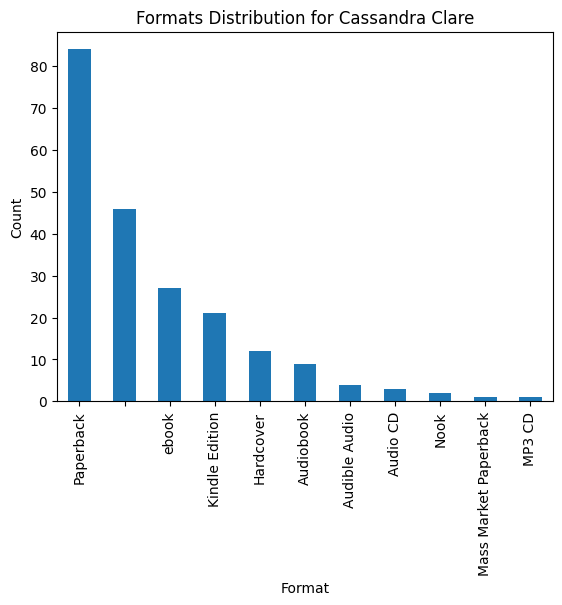

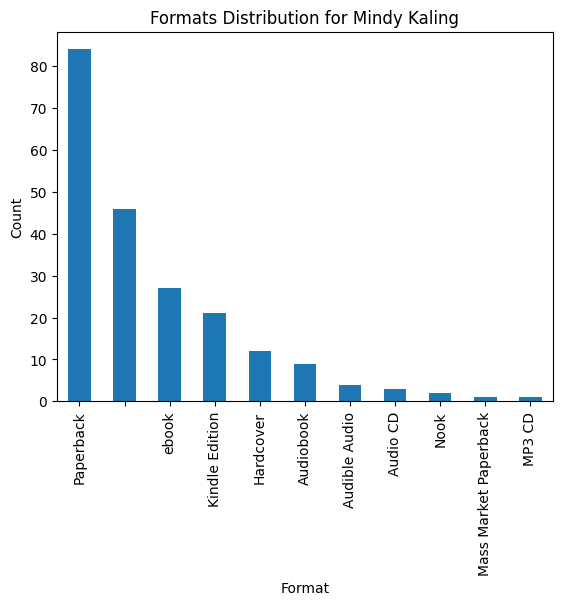

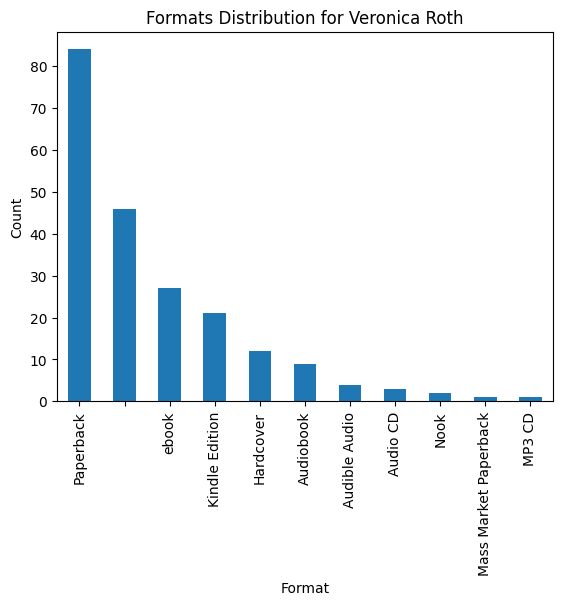

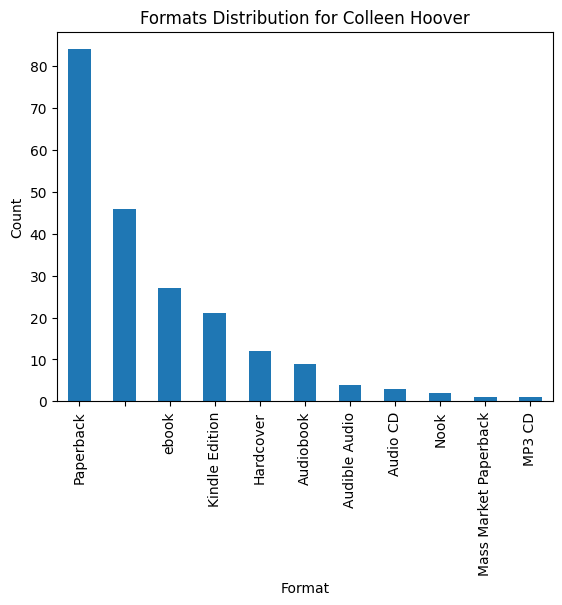

In [42]:
#To find the authors published in different formats from the top 10

authors_with_different_formats = top_authors_books[top_authors_books.duplicated(subset=["author_id"], keep=False)]

#to avoid name repetition
unique_author_ids = authors_with_different_formats["author_id"].unique()

# Create a separate chart for each author with multiple formats
for author_id in unique_author_ids:
    author_data = authors_with_different_formats[authors_with_different_formats["author_id"] == author_id]
    author_name = author_data["author_name"].values[0]
    if not author_data["format"].isnull:
        format_distribution = author_data["format"].value_counts()
    
    format_distribution.plot(kind='bar')
    plt.title(f"Formats Distribution for {author_name}")
    plt.xlabel("Format")
    plt.ylabel("Count")
    plt.show()

Comments on the graphs above:

We can see that the books are mainly published in paperback and hardcover formats, whereas the "newer" digital formats are very few. This would be due to 3 main reasons: 
1- the age of most of the books written by these authors since audiobooks and ebook formats are relatively new.
2- even with more widely available digital formats now, these are authors of novels and readers who usually enjoy leisurely reading prefer the physical format of paper, rather than reading through a screen.
3- Once a book has been published in a digital format, there is no need to republish it using another editorial, since it is already on the internet, a more universal "bookstore".


**Request 5.3:** Provide information about the general response from readers (number of fans, average rating, number of reviews, etc.), divide the authors by gender, and comment about anything eventually related to “structural bias.”

# [RQ6] For this question, consider the top 10 authors concerning the number of fans again. 


    Provide the average time gap between two subsequent publications for a series of books and those not belonging to a series. What do you expect to see, and what is the actual answer to this question?
    For each of the authors, give a convenient plot showing how many books has the given author published UP TO a given year. Are these authors contemporary with each other? Can you notice a range of years where their production rate was higher?


**Request 6.1:** Provide the average time gap between two subsequent publications for a series of books and those not belonging to a series. What do you expect to see, and what is the actual answer to this question?

In [4]:
#Step 1: transform the publication date entry to datetime format

top_authors_books["original_publication_date"] = pd.to_datetime(top_authors_books["original_publication_date"], format = 'mixed')

#calculate time gap between consecutive "original" publications and add it into a column for all books
top_authors_books["time_gap"] = top_authors_books.groupby(["author_id", "series_id"])["original_publication_date"].diff()

# Calculate the average time gap for books in a series and not in a series, according to the new column created
average_time_gap_series = top_authors_books[top_authors_books["series_id"].notna()]["time_gap"].mean()
average_time_gap_non_series = top_authors_books[top_authors_books["series_id"].isna()]["time_gap"].mean()

#print(f"Average Time Gap for Books in a Series: {average_time_gap_series}")
#print(f"Average Time Gap for Books Not in a Series: {average_time_gap_non_series}")
print(top_authors_books)

NameError: name 'top_authors_books' is not defined

What do we expect to see?

As expected the books that belong to a series have a more periodic and regular output from the authors(on average), and this logically makes sense following the idea that the author is breaking down a full story into separate books.
Books that do not belong to a series however do not have a well-defined average gap between them since they are independent works and do not follow any periodic output "expectation" from the public.

**Request 6.2:** For each of the authors, give a convenient plot showing how many books has the given author published UP TO a given year. Are these authors contemporary with each other? Can you notice a range of years where their production rate was higher?

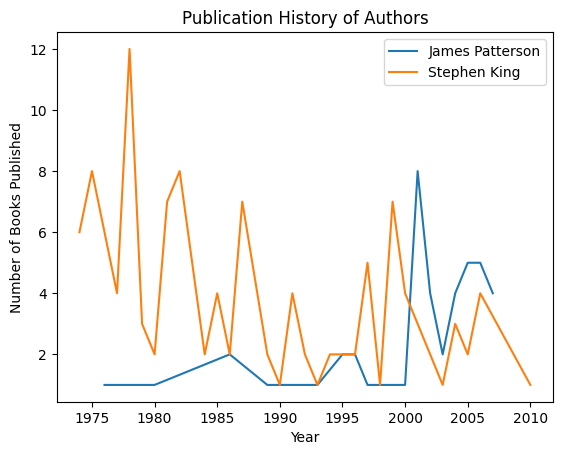

In [72]:
#define a new column using the datetime format of the original publication date
top_authors_books['year'] = top_authors_books["original_publication_date"].dt.year
writers_counts = top_authors_books.groupby(['author_name', 'year']).size().reset_index(name='Count')

# Plot the publication history for each author
writers = writers_counts['author_name'].unique()
for writer in writers:
    author_data = writers_counts[writers_counts['author_name'] == writer]
    plt.plot(author_data['year'], author_data['Count'], label=writer)

plt.title("Publication History of Authors")
plt.xlabel("Year")
plt.ylabel("Number of Books Published")
plt.legend()
plt.show()

# [RQ7] Estimating probabilities is a core skill for a data scientist: show us your best!

# [RQ8] Charts, statistical tests, and analysis methods are splendid tools to illustrate your data-driven decisions to check whether a hypothesis is correct.